In [2]:
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

torch.backends.cudnn.benchmark = True  # Speeds up GPU computation

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageDataset(Dataset):
    def __init__(self, dataset_root, transform=None, num_frames=10):
        """
        Args:
            dataset_root (str): Path to extracted frame dataset.
            transform: PyTorch transforms.
            num_frames (int): Frames per sample.
        """
        self.dataset_root = Path(dataset_root)
        self.transform = transform
        self.num_frames = num_frames
        self.image_pairs = []
        self.pair_sources = []  # Track the real_folder name for each pair

        # Iterate through the real video folders
        for real_folder in self.dataset_root.iterdir():
            if real_folder.is_dir():
                # ✅ Step into the subfolder that has the same name as the real video
                real_subfolder = real_folder / real_folder.name

                if not real_subfolder.exists():  # Skip if the expected subfolder is missing
                    print(f"⚠️ Missing real subfolder: {real_subfolder}")
                    continue

                real_images = sorted(real_subfolder.glob("*.jpg"))[:num_frames]

                # Find fake video folders (everything else inside `real_folder`)
                fake_folders = [f for f in real_folder.iterdir() if f.is_dir() and f.name != real_folder.name]

                for fake_folder in fake_folders:
                    fake_images = sorted(fake_folder.glob("*.jpg"))[:num_frames]

                    if real_images and fake_images:
                        self.image_pairs.append((real_images, fake_images))
                        self.pair_sources.append(real_folder.name)  # <-- Save video/person ID here

        print(f"✅ Dataset loaded with {len(self.image_pairs)} real-fake pairs.")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        real_images, fake_images = self.image_pairs[idx]

        # Load and transform images
        real_frames = [self.transform(Image.open(img)) for img in real_images]
        fake_frames = [self.transform(Image.open(img)) for img in fake_images]

        real_tensor = torch.stack(real_frames)
        fake_tensor = torch.stack(fake_frames)

        # ✅ Assign Labels
        real_label = torch.tensor(1, dtype=torch.float32)  # Real videos get label 1
        fake_label = torch.tensor(0, dtype=torch.float32)  # Fake videos get label 0

        return real_tensor, real_label, fake_tensor, fake_label  # Return images + labels

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_root = "processed_dataset"  # Use extracted images
dataset = ImageDataset(dataset_root=dataset_root, transform=transform, num_frames=10)

✅ Dataset loaded with 5639 real-fake pairs.


In [ ]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Get dataset indices and shuffle them
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Compute split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create index splits
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
print("Samplers created")

# Create DataLoaders
train_loader = DataLoader(dataset, batch_size=4, sampler=train_sampler, pin_memory=False)
val_loader = DataLoader(dataset, batch_size=4, sampler=val_sampler, pin_memory=False)
test_loader = DataLoader(dataset, batch_size=4, sampler=test_sampler, pin_memory=False)
print("DataLoaders created")

print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")


Samplers created
DataLoaders created
Train: 3947, Val: 845, Test: 847


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepFakeTemporalComparator(nn.Module):
    def __init__(self, freeze_resnet=False, lstm_hidden_size=128, lstm_layers=1):
        super(DeepFakeTemporalComparator, self).__init__()
        # Use ResNet18 as a feature extractor; remove its final classification layer.
        self.feature_extractor = models.resnet18(pretrained=True)
        self.feature_extractor.fc = nn.Identity()

        # Optionally freeze ResNet weights
        if freeze_resnet:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        # LSTM to capture temporal differences
        # The input size is 512 (ResNet feature dim)
        self.lstm = nn.LSTM(input_size=512, hidden_size=lstm_hidden_size, 
                            num_layers=lstm_layers, batch_first=True)
        
        # Final classification layer that maps LSTM output to a single logit
        self.fc = nn.Linear(lstm_hidden_size, 1)
        
    def forward(self, real_x, fake_x):
        """
        real_x, fake_x: Tensors of shape (batch_size, num_frames, C, H, W)
        """
        batch_size, num_frames, C, H, W = real_x.shape

        # Flatten frames: (batch_size*num_frames, C, H, W)
        real_x = real_x.view(-1, C, H, W)
        fake_x = fake_x.view(-1, C, H, W)

        # Extract features with ResNet18
        real_features = self.feature_extractor(real_x)  # (batch_size*num_frames, 512)
        fake_features = self.feature_extractor(fake_x)    # (batch_size*num_frames, 512)

        # Reshape back to (batch_size, num_frames, feature_dim)
        real_features = real_features.view(batch_size, num_frames, -1)
        fake_features = fake_features.view(batch_size, num_frames, -1)

        # Compute the per-frame directional difference between features
        diff_features = real_features - fake_features  # (batch_size, num_frames, 512)

        # Feed the sequence of differences into the LSTM
        # lstm_out has shape: (batch_size, num_frames, lstm_hidden_size)
        lstm_out, _ = self.lstm(diff_features)

        # Use the final time step's output as the summary representation
        final_hidden = lstm_out[:, -1, :]  # (batch_size, lstm_hidden_size)

        # Compute final logit for binary classification
        out = self.fc(final_hidden)  # (batch_size, 1)

        # Return raw logits for use with BCEWithLogitsLoss
        return out

In [ ]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeTemporalComparator().to(device)
# criterion = torch.nn.BCELoss()  # Binary classification loss
criterion = torch.nn.BCEWithLogitsLoss()  # Replaces BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30  # Number of epochs

# Track loss & metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
best_val_loss = float("inf")  # Store best validation loss
best_model_path = "best_deepfake_model.pth"

for epoch in range(num_epochs):
    #### ---------------- TRAINING ---------------- ####
    model.train()
    train_loss, correct_preds, total_samples = 0.0, 0, 0
    all_labels, all_preds = [], []

    print(f"\n🔵 Epoch {epoch+1}/{num_epochs} - Training")
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for real_batch, real_labels, fake_batch, fake_labels in train_bar:
        real_batch, fake_batch = real_batch.to(device), fake_batch.to(device)
        real_labels, fake_labels = real_labels.to(device), fake_labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass real and fake separately
        real_preds = model(real_batch, fake_batch)  # Shape: (batch_size, 1)
        fake_preds = model(fake_batch, real_batch)  # Reverse for fake

        # Concatenate predictions to match labels
        predictions = torch.cat((real_preds, fake_preds), dim=0)  # Shape: (2 * batch_size, 1)

        # Concatenate real and fake labels
        labels = torch.cat((real_labels, fake_labels), dim=0).unsqueeze(1)  # Shape: (2 * batch_size, 1)

        # Compute loss
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * predictions.size(0)  # For training        

        # Convert logits to probabilities
        probs = torch.sigmoid(predictions)
        preds = (probs > 0.5).float()

        correct_preds += (preds.view(-1) == labels.view(-1)).sum().item()
        total_samples += labels.numel()  # Total samples

        # Store for precision/recall metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Update tqdm progress bar
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Store train loss for plotting

    # Calculate Accuracy, Precision, Recall, and F1
    train_acc = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, zero_division=0)
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, zero_division=0)

    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    #### ---------------- VALIDATION ---------------- ####
    model.eval()
    val_loss, correct_preds, total_samples = 0.0, 0, 0
    all_labels, all_preds = [], []

    print(f"🟡 Epoch {epoch+1}/{num_epochs} - Validation")
    val_bar = tqdm(val_loader, desc=f"Validation")

    with torch.no_grad():  # No gradients in validation
        for real_batch, real_labels, fake_batch, fake_labels in val_bar:
            real_batch, fake_batch = real_batch.to(device), fake_batch.to(device)
            real_labels, fake_labels = real_labels.to(device), fake_labels.to(device)

            # ✅ FIX: Forward pass real and fake for validation too
            real_preds = model(real_batch, fake_batch)
            fake_preds = model(fake_batch, real_batch)

            # Concatenate predictions and labels
            val_preds = torch.cat((real_preds, fake_preds), dim=0)
            val_labels = torch.cat((real_labels, fake_labels), dim=0).unsqueeze(1)

            loss = criterion(val_preds, val_labels)
            val_loss += loss.item() * val_preds.size(0)

            # Convert predictions to binary (threshold = 0.5)
            # preds = (val_preds > 0.5).float()

            # Convert logits to probabilities
            probs = torch.sigmoid(val_preds)
            preds = (probs > 0.5).float()


            correct_preds += (preds.view(-1) == val_labels.view(-1)).sum().item()
            total_samples += val_labels.numel()

            # Store for precision/recall metrics
            all_labels.extend(val_labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update tqdm progress bar
            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store val loss for plotting

    # Calculate Accuracy, Precision, Recall, and F1
    val_acc = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # Print Training & Validation Metrics
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"📊 Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    print(f"🎯 Train Precision: {train_precision:.4f}, Val Precision: {val_precision:.4f}")
    print(f"📢 Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}")
    print(f"🔥 Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 New Best Model Saved: {best_model_path}")

print("\n🎉 Training Complete!")
print(f"Best Model Validation Loss: {best_val_loss:.4f}")

# Save final model
torch.save(model.state_dict(), "final_deepfake_model.pth")
print("📁 Final model saved as 'final_deepfake_model.pth'")

c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔵 Epoch 1/30 - Training


Epoch 1/30: 100%|██████████| 987/987 [13:19<00:00,  1.24it/s, loss=0.6233]


🟡 Epoch 1/30 - Validation


Validation: 100%|██████████| 212/212 [01:58<00:00,  1.79it/s, loss=0.6923]


✅ Epoch [1/30] - Train Loss: 0.9696, Val Loss: 0.2063
📊 Train Acc: 0.5053, Val Acc: 0.5160
🎯 Train Precision: 0.5050, Val Precision: 0.5112
📢 Train Recall: 0.5369, Val Recall: 0.7266
🔥 Train F1: 0.5204, Val F1: 0.6002
🔥 New Best Model Saved: best_deepfake_model.pth

🔵 Epoch 2/30 - Training


Epoch 2/30: 100%|██████████| 987/987 [13:23<00:00,  1.23it/s, loss=0.6375]


🟡 Epoch 2/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.7992]


✅ Epoch [2/30] - Train Loss: 0.9657, Val Loss: 0.2157
📊 Train Acc: 0.5247, Val Acc: 0.3379
🎯 Train Precision: 0.5241, Val Precision: 0.2979
📢 Train Recall: 0.5379, Val Recall: 0.2391
🔥 Train F1: 0.5309, Val F1: 0.2653

🔵 Epoch 3/30 - Training


Epoch 3/30: 100%|██████████| 987/987 [13:26<00:00,  1.22it/s, loss=0.7037]


🟡 Epoch 3/30 - Validation


Validation: 100%|██████████| 212/212 [02:01<00:00,  1.75it/s, loss=0.6068]


✅ Epoch [3/30] - Train Loss: 0.9680, Val Loss: 0.2014
📊 Train Acc: 0.5213, Val Acc: 0.6970
🎯 Train Precision: 0.5214, Val Precision: 0.7105
📢 Train Recall: 0.5181, Val Recall: 0.6651
🔥 Train F1: 0.5198, Val F1: 0.6870
🔥 New Best Model Saved: best_deepfake_model.pth

🔵 Epoch 4/30 - Training


Epoch 4/30: 100%|██████████| 987/987 [13:35<00:00,  1.21it/s, loss=0.6757]


🟡 Epoch 4/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.7654]


✅ Epoch [4/30] - Train Loss: 0.9603, Val Loss: 0.2109
📊 Train Acc: 0.5385, Val Acc: 0.3621
🎯 Train Precision: 0.5376, Val Precision: 0.3684
📢 Train Recall: 0.5511, Val Recall: 0.3858
🔥 Train F1: 0.5442, Val F1: 0.3769

🔵 Epoch 5/30 - Training


Epoch 5/30: 100%|██████████| 987/987 [13:21<00:00,  1.23it/s, loss=0.7037]


🟡 Epoch 5/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.81it/s, loss=0.2112]


✅ Epoch [5/30] - Train Loss: 0.9453, Val Loss: 0.2131
📊 Train Acc: 0.5739, Val Acc: 0.3189
🎯 Train Precision: 0.5755, Val Precision: 0.3048
📢 Train Recall: 0.5632, Val Recall: 0.2828
🔥 Train F1: 0.5693, Val F1: 0.2934

🔵 Epoch 6/30 - Training


Epoch 6/30: 100%|██████████| 987/987 [13:23<00:00,  1.23it/s, loss=0.6968]


🟡 Epoch 6/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=1.2420]


✅ Epoch [6/30] - Train Loss: 0.9231, Val Loss: 0.2292
📊 Train Acc: 0.6046, Val Acc: 0.4254
🎯 Train Precision: 0.6016, Val Precision: 0.4142
📢 Train Recall: 0.6195, Val Recall: 0.3598
🔥 Train F1: 0.6104, Val F1: 0.3851

🔵 Epoch 7/30 - Training


Epoch 7/30: 100%|██████████| 987/987 [13:18<00:00,  1.24it/s, loss=0.0012]


🟡 Epoch 7/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.81it/s, loss=0.9036]


✅ Epoch [7/30] - Train Loss: 0.4843, Val Loss: 0.2579
📊 Train Acc: 0.8282, Val Acc: 0.5923
🎯 Train Precision: 0.8233, Val Precision: 0.5712
📢 Train Recall: 0.8358, Val Recall: 0.7408
🔥 Train F1: 0.8295, Val F1: 0.6450

🔵 Epoch 8/30 - Training


Epoch 8/30: 100%|██████████| 987/987 [13:22<00:00,  1.23it/s, loss=0.0006]


🟡 Epoch 8/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.0622]


✅ Epoch [8/30] - Train Loss: 0.0645, Val Loss: 0.1774
📊 Train Acc: 0.9862, Val Acc: 0.7615
🎯 Train Precision: 0.9861, Val Precision: 0.7278
📢 Train Recall: 0.9863, Val Recall: 0.8355
🔥 Train F1: 0.9862, Val F1: 0.7780
🔥 New Best Model Saved: best_deepfake_model.pth

🔵 Epoch 9/30 - Training


Epoch 9/30: 100%|██████████| 987/987 [13:17<00:00,  1.24it/s, loss=0.0030]


🟡 Epoch 9/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.81it/s, loss=0.0495]


✅ Epoch [9/30] - Train Loss: 0.0708, Val Loss: 0.1994
📊 Train Acc: 0.9871, Val Acc: 0.6675
🎯 Train Precision: 0.9871, Val Precision: 0.6884
📢 Train Recall: 0.9871, Val Recall: 0.6118
🔥 Train F1: 0.9871, Val F1: 0.6479

🔵 Epoch 10/30 - Training


Epoch 10/30: 100%|██████████| 987/987 [13:15<00:00,  1.24it/s, loss=0.0047]


🟡 Epoch 10/30 - Validation


Validation: 100%|██████████| 212/212 [01:56<00:00,  1.81it/s, loss=0.2724]


✅ Epoch [10/30] - Train Loss: 0.0399, Val Loss: 0.2167
📊 Train Acc: 0.9913, Val Acc: 0.6959
🎯 Train Precision: 0.9914, Val Precision: 0.6913
📢 Train Recall: 0.9911, Val Recall: 0.7077
🔥 Train F1: 0.9913, Val F1: 0.6994

🔵 Epoch 11/30 - Training


Epoch 11/30: 100%|██████████| 987/987 [13:16<00:00,  1.24it/s, loss=0.0007]


🟡 Epoch 11/30 - Validation


Validation: 100%|██████████| 212/212 [01:58<00:00,  1.79it/s, loss=0.0091]


✅ Epoch [11/30] - Train Loss: 0.0556, Val Loss: 0.1000
📊 Train Acc: 0.9868, Val Acc: 0.8675
🎯 Train Precision: 0.9853, Val Precision: 0.8782
📢 Train Recall: 0.9883, Val Recall: 0.8533
🔥 Train F1: 0.9868, Val F1: 0.8655
🔥 New Best Model Saved: best_deepfake_model.pth

🔵 Epoch 12/30 - Training


Epoch 12/30: 100%|██████████| 987/987 [13:19<00:00,  1.24it/s, loss=0.0642]


🟡 Epoch 12/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.1871]


✅ Epoch [12/30] - Train Loss: 0.0472, Val Loss: 0.1082
📊 Train Acc: 0.9899, Val Acc: 0.8456
🎯 Train Precision: 0.9901, Val Precision: 0.8113
📢 Train Recall: 0.9896, Val Recall: 0.9006
🔥 Train F1: 0.9899, Val F1: 0.8536

🔵 Epoch 13/30 - Training


Epoch 13/30: 100%|██████████| 987/987 [13:19<00:00,  1.23it/s, loss=0.0001]


🟡 Epoch 13/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.2070]


✅ Epoch [13/30] - Train Loss: 0.0335, Val Loss: 0.2483
📊 Train Acc: 0.9911, Val Acc: 0.6609
🎯 Train Precision: 0.9919, Val Precision: 0.6538
📢 Train Recall: 0.9904, Val Recall: 0.6840
🔥 Train F1: 0.9911, Val F1: 0.6686

🔵 Epoch 14/30 - Training


Epoch 14/30: 100%|██████████| 987/987 [13:31<00:00,  1.22it/s, loss=0.0000]


🟡 Epoch 14/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.80it/s, loss=0.0001]


✅ Epoch [14/30] - Train Loss: 0.0255, Val Loss: 0.1241
📊 Train Acc: 0.9933, Val Acc: 0.8609
🎯 Train Precision: 0.9929, Val Precision: 0.8971
📢 Train Recall: 0.9937, Val Recall: 0.8154
🔥 Train F1: 0.9933, Val F1: 0.8543

🔵 Epoch 15/30 - Training


Epoch 15/30: 100%|██████████| 987/987 [13:16<00:00,  1.24it/s, loss=0.0004]


🟡 Epoch 15/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=1.7003]


✅ Epoch [15/30] - Train Loss: 0.0317, Val Loss: 0.3021
📊 Train Acc: 0.9919, Val Acc: 0.5740
🎯 Train Precision: 0.9914, Val Precision: 0.5711
📢 Train Recall: 0.9924, Val Recall: 0.5941
🔥 Train F1: 0.9919, Val F1: 0.5824

🔵 Epoch 16/30 - Training


Epoch 16/30: 100%|██████████| 987/987 [12:54<00:00,  1.27it/s, loss=0.0299]


🟡 Epoch 16/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.1422]


✅ Epoch [16/30] - Train Loss: 0.0087, Val Loss: 0.4433
📊 Train Acc: 0.9976, Val Acc: 0.3811
🎯 Train Precision: 0.9970, Val Precision: 0.3554
📢 Train Recall: 0.9982, Val Recall: 0.2923
🔥 Train F1: 0.9976, Val F1: 0.3208

🔵 Epoch 17/30 - Training


Epoch 17/30: 100%|██████████| 987/987 [12:53<00:00,  1.28it/s, loss=0.1827]


🟡 Epoch 17/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.0456]


✅ Epoch [17/30] - Train Loss: 0.0364, Val Loss: 0.1585
📊 Train Acc: 0.9916, Val Acc: 0.7852
🎯 Train Precision: 0.9921, Val Precision: 0.7789
📢 Train Recall: 0.9911, Val Recall: 0.7964
🔥 Train F1: 0.9916, Val F1: 0.7876

🔵 Epoch 18/30 - Training


Epoch 18/30: 100%|██████████| 987/987 [12:52<00:00,  1.28it/s, loss=0.0001]


🟡 Epoch 18/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.0063]


✅ Epoch [18/30] - Train Loss: 0.0223, Val Loss: 0.1463
📊 Train Acc: 0.9958, Val Acc: 0.8195
🎯 Train Precision: 0.9957, Val Precision: 0.8309
📢 Train Recall: 0.9959, Val Recall: 0.8024
🔥 Train F1: 0.9958, Val F1: 0.8164

🔵 Epoch 19/30 - Training


Epoch 19/30: 100%|██████████| 987/987 [12:53<00:00,  1.28it/s, loss=0.0001]


🟡 Epoch 19/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.86it/s, loss=1.5646]


✅ Epoch [19/30] - Train Loss: 0.0305, Val Loss: 0.2252
📊 Train Acc: 0.9921, Val Acc: 0.6183
🎯 Train Precision: 0.9916, Val Precision: 0.6134
📢 Train Recall: 0.9927, Val Recall: 0.6402
🔥 Train F1: 0.9921, Val F1: 0.6265

🔵 Epoch 20/30 - Training


Epoch 20/30: 100%|██████████| 987/987 [12:53<00:00,  1.28it/s, loss=0.0000]


🟡 Epoch 20/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.0103]


✅ Epoch [20/30] - Train Loss: 0.0169, Val Loss: 0.1146
📊 Train Acc: 0.9957, Val Acc: 0.8550
🎯 Train Precision: 0.9957, Val Precision: 0.8505
📢 Train Recall: 0.9957, Val Recall: 0.8615
🔥 Train F1: 0.9957, Val F1: 0.8560

🔵 Epoch 21/30 - Training


Epoch 21/30: 100%|██████████| 987/987 [12:54<00:00,  1.27it/s, loss=0.0000]


🟡 Epoch 21/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=8.4026] 


✅ Epoch [21/30] - Train Loss: 0.0019, Val Loss: 1.7427
📊 Train Acc: 0.9996, Val Acc: 0.1320
🎯 Train Precision: 0.9995, Val Precision: 0.1425
📢 Train Recall: 0.9997, Val Recall: 0.1467
🔥 Train F1: 0.9996, Val F1: 0.1446

🔵 Epoch 22/30 - Training


Epoch 22/30: 100%|██████████| 987/987 [12:52<00:00,  1.28it/s, loss=0.1352]


🟡 Epoch 22/30 - Validation


Validation: 100%|██████████| 212/212 [01:54<00:00,  1.86it/s, loss=0.6512]


✅ Epoch [22/30] - Train Loss: 0.0275, Val Loss: 0.1149
📊 Train Acc: 0.9908, Val Acc: 0.8586
🎯 Train Precision: 0.9909, Val Precision: 0.8651
📢 Train Recall: 0.9906, Val Recall: 0.8497
🔥 Train F1: 0.9908, Val F1: 0.8573

🔵 Epoch 23/30 - Training


Epoch 23/30: 100%|██████████| 987/987 [12:55<00:00,  1.27it/s, loss=0.0001] 


🟡 Epoch 23/30 - Validation


Validation: 100%|██████████| 212/212 [01:54<00:00,  1.86it/s, loss=0.0004]


✅ Epoch [23/30] - Train Loss: 0.0175, Val Loss: 0.4656
📊 Train Acc: 0.9985, Val Acc: 0.4604
🎯 Train Precision: 0.9987, Val Precision: 0.4608
📢 Train Recall: 0.9982, Val Recall: 0.4663
🔥 Train F1: 0.9985, Val F1: 0.4635

🔵 Epoch 24/30 - Training


Epoch 24/30: 100%|██████████| 987/987 [12:57<00:00,  1.27it/s, loss=0.0003]


🟡 Epoch 24/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.86it/s, loss=3.3095]


✅ Epoch [24/30] - Train Loss: 0.0153, Val Loss: 0.8240
📊 Train Acc: 0.9977, Val Acc: 0.3266
🎯 Train Precision: 0.9980, Val Precision: 0.3274
📢 Train Recall: 0.9975, Val Recall: 0.3290
🔥 Train F1: 0.9977, Val F1: 0.3282

🔵 Epoch 25/30 - Training


Epoch 25/30: 100%|██████████| 987/987 [12:53<00:00,  1.28it/s, loss=0.0002]


🟡 Epoch 25/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.0670]


✅ Epoch [25/30] - Train Loss: 0.0208, Val Loss: 0.8125
📊 Train Acc: 0.9956, Val Acc: 0.2710
🎯 Train Precision: 0.9949, Val Precision: 0.2133
📢 Train Recall: 0.9962, Val Recall: 0.1704
🔥 Train F1: 0.9956, Val F1: 0.1895

🔵 Epoch 26/30 - Training


Epoch 26/30: 100%|██████████| 987/987 [12:52<00:00,  1.28it/s, loss=0.0002]


🟡 Epoch 26/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.87it/s, loss=0.0002]


✅ Epoch [26/30] - Train Loss: 0.0166, Val Loss: 0.0858
📊 Train Acc: 0.9958, Val Acc: 0.8491
🎯 Train Precision: 0.9962, Val Precision: 0.8479
📢 Train Recall: 0.9954, Val Recall: 0.8509
🔥 Train F1: 0.9958, Val F1: 0.8494
🔥 New Best Model Saved: best_deepfake_model.pth

🔵 Epoch 27/30 - Training


Epoch 27/30: 100%|██████████| 987/987 [12:52<00:00,  1.28it/s, loss=0.0010]


🟡 Epoch 27/30 - Validation


Validation: 100%|██████████| 212/212 [01:54<00:00,  1.86it/s, loss=0.6009]


✅ Epoch [27/30] - Train Loss: 0.0169, Val Loss: 0.1991
📊 Train Acc: 0.9961, Val Acc: 0.5929
🎯 Train Precision: 0.9959, Val Precision: 0.5745
📢 Train Recall: 0.9962, Val Recall: 0.7160
🔥 Train F1: 0.9961, Val F1: 0.6375

🔵 Epoch 28/30 - Training


Epoch 28/30: 100%|██████████| 987/987 [13:06<00:00,  1.25it/s, loss=0.0000]


🟡 Epoch 28/30 - Validation


Validation: 100%|██████████| 212/212 [01:57<00:00,  1.81it/s, loss=0.6512]


✅ Epoch [28/30] - Train Loss: 0.0018, Val Loss: 0.6441
📊 Train Acc: 0.9997, Val Acc: 0.1751
🎯 Train Precision: 0.9997, Val Precision: 0.1720
📢 Train Recall: 0.9997, Val Recall: 0.1704
🔥 Train F1: 0.9997, Val F1: 0.1712

🔵 Epoch 29/30 - Training


Epoch 29/30: 100%|██████████| 987/987 [13:02<00:00,  1.26it/s, loss=0.0000]


🟡 Epoch 29/30 - Validation


Validation: 100%|██████████| 212/212 [01:54<00:00,  1.86it/s, loss=0.5839]


✅ Epoch [29/30] - Train Loss: 0.0002, Val Loss: 0.5688
📊 Train Acc: 1.0000, Val Acc: 0.3367
🎯 Train Precision: 1.0000, Val Precision: 0.3365
📢 Train Recall: 1.0000, Val Recall: 0.3361
🔥 Train F1: 1.0000, Val F1: 0.3363

🔵 Epoch 30/30 - Training


Epoch 30/30: 100%|██████████| 987/987 [12:54<00:00,  1.27it/s, loss=0.0000]


🟡 Epoch 30/30 - Validation


Validation: 100%|██████████| 212/212 [01:53<00:00,  1.86it/s, loss=0.0001]


✅ Epoch [30/30] - Train Loss: 0.0001, Val Loss: 0.2808
📊 Train Acc: 1.0000, Val Acc: 0.6172
🎯 Train Precision: 1.0000, Val Precision: 0.6115
📢 Train Recall: 1.0000, Val Recall: 0.6426
🔥 Train F1: 1.0000, Val F1: 0.6267

🎉 Training Complete!
Best Model Validation Loss: 0.0858
📁 Final model saved as 'final_deepfake_model.pth'


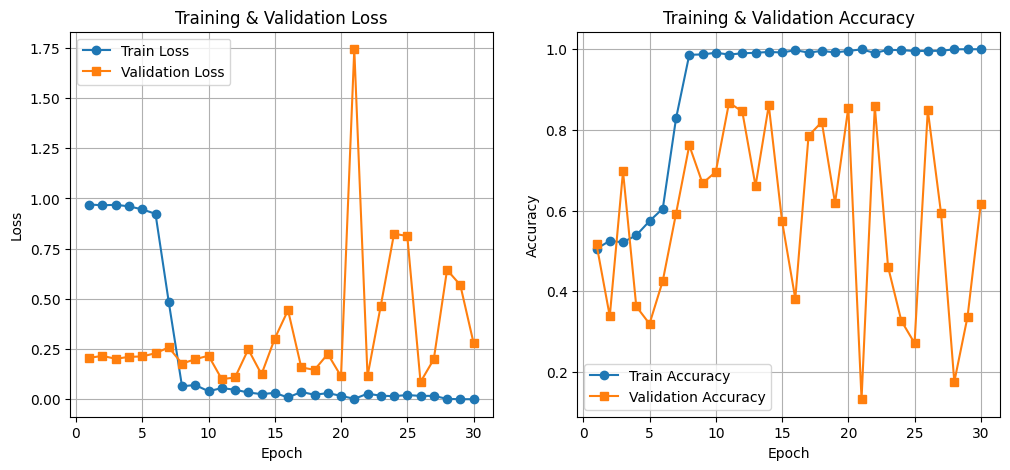

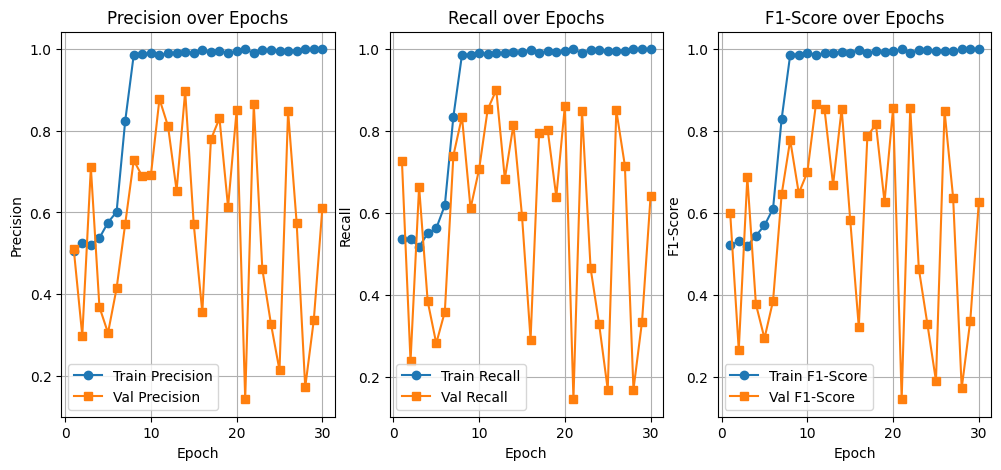

In [12]:
#### ---------------- PLOTTING LOSS & METRICS ---------------- ####
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

# Additional Plots for Precision, Recall, and F1
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_precisions, label="Train Precision", marker='o')
plt.plot(range(1, num_epochs + 1), val_precisions, label="Val Precision", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_recalls, label="Train Recall", marker='o')
plt.plot(range(1, num_epochs + 1), val_recalls, label="Val Recall", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), train_f1s, label="Train F1-Score", marker='o')
plt.plot(range(1, num_epochs + 1), val_f1s, label="Val F1-Score", marker='s')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.title("F1-Score over Epochs")
plt.legend()
plt.grid()

plt.show()

In [26]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# -------------------------------------------
# 🧠 Model Loading
# -------------------------------------------
# Initialize the model
model = DeepFakeTemporalComparator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the saved weights
model.load_state_dict(torch.load("best_deepfake_model.pth", map_location=device))
print("✅ Model loaded successfully!")
model.eval()  # Set to evaluation mode

# -------------------------------------------
# 📉 Evaluation + Full Example Storage
# -------------------------------------------
# Set mean and std for de-normalization (ImageNet values)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# De-normalization function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Helper to plot images
def plot_image(tensor, title=""):
    tensor = tensor.cpu()
    plt.imshow(tensor.permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Initialize variables for loss and accuracy
test_loss = 0.0
correct_preds = 0
total_samples = 0

# Lists to store ALL examples and labels
all_examples = []  # Format: (img_tensor, true_label, pred_label, is_correct)
all_preds = []
all_labels = []

with torch.no_grad():
    for real_batch, real_labels, fake_batch, fake_labels in test_loader:
        real_batch, fake_batch = real_batch.to(device), fake_batch.to(device)
        real_labels, fake_labels = real_labels.to(device), fake_labels.to(device)

        # Forward pass
        test_preds_real = model(real_batch, fake_batch)
        test_preds_fake = model(fake_batch, real_batch)

        # Concatenate predictions and labels
        test_preds = torch.cat((test_preds_real, test_preds_fake), dim=0)
        test_labels = torch.cat((real_labels, fake_labels), dim=0).unsqueeze(1)
        images = torch.cat((real_batch, fake_batch), dim=0)  # (2*batch_size, num_frames, C, H, W)

        # Compute loss
        loss = criterion(test_preds, test_labels)
        test_loss += loss.item() * test_preds.size(0)

        # Compute accuracy
        probs = torch.sigmoid(test_preds)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply threshold

        correct_preds += (preds == test_labels).sum().item()
        total_samples += test_labels.size(0)

        # Store ALL Examples and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

        for i in range(test_preds.size(0)):
            # Select first frame for visualization
            img_tensor = images[i][0]  # Shape: (C, H, W)
            img_tensor = denormalize(img_tensor.clone(), mean, std)

            # Store (image, true_label, pred_label, is_correct)
            is_correct = preds[i].item() == test_labels[i].item()
            all_examples.append((img_tensor, int(test_labels[i].item()), int(preds[i].item()), is_correct))

# -------------------------------------------
# 📊 Results and Metrics
# -------------------------------------------
# Calculate basic metrics
avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, zero_division=0)
test_recall = recall_score(all_labels, all_preds, zero_division=0)
test_f1 = f1_score(all_labels, all_preds, zero_division=0)
test_conf_matrix = confusion_matrix(all_labels, all_preds)

# Print Metrics
print(f"📉 Test Loss: {avg_test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
print(f"💡 Precision: {test_precision:.4f}")
print(f"📢 Recall: {test_recall:.4f}")
print(f"🔥 F1 Score: {test_f1:.4f}")
print(f"🧮 Confusion Matrix:\n{test_conf_matrix}")
print("✅ Testing complete!")

c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\najib\AppData\Local\Temp\ipykernel_23244\2912074584.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

✅ Model loaded successfully!
📉 Test Loss: 0.0780
🎯 Test Accuracy: 0.8754
💡 Precision: 0.8732
📢 Recall: 0.8784
🔥 F1 Score: 0.8758
🧮 Confusion Matrix:
[[739 108]
 [103 744]]
✅ Testing complete!



✅ Plotting 20 Correct Predictions:


c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


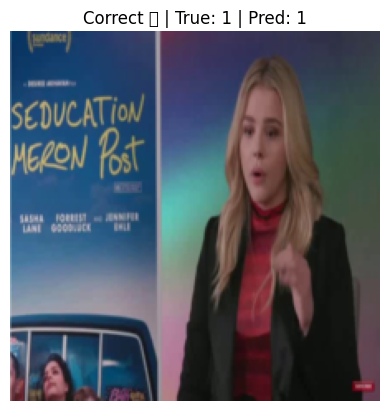

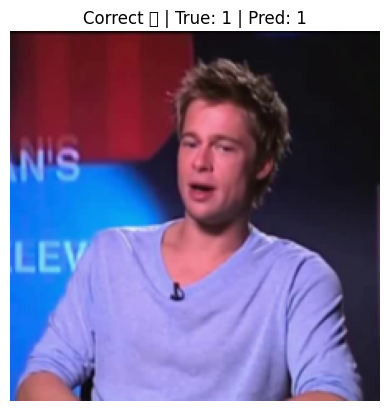

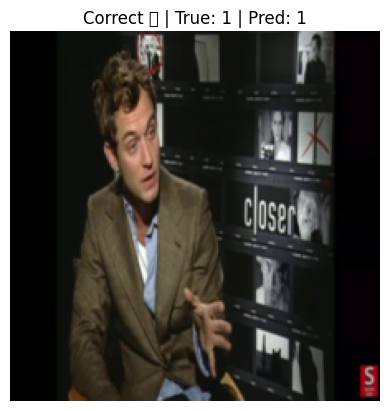

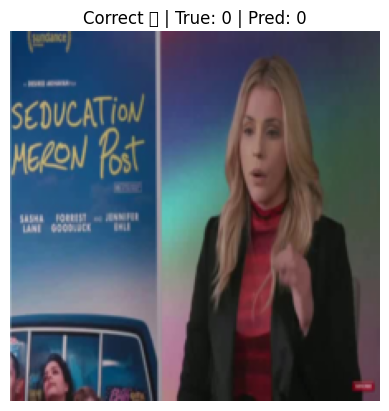

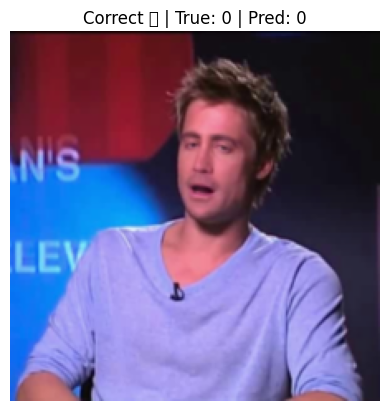

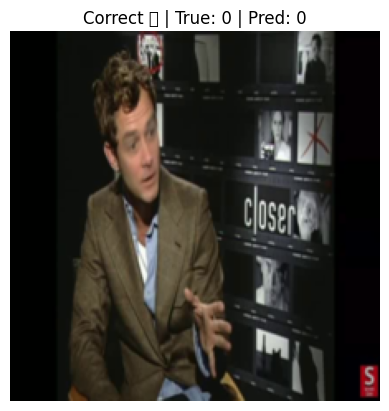

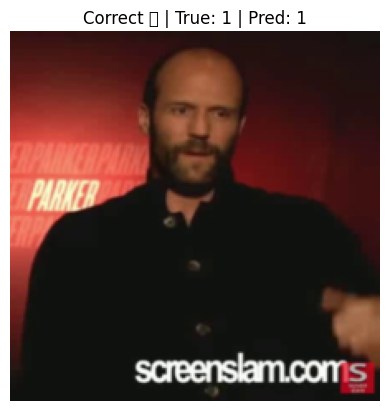

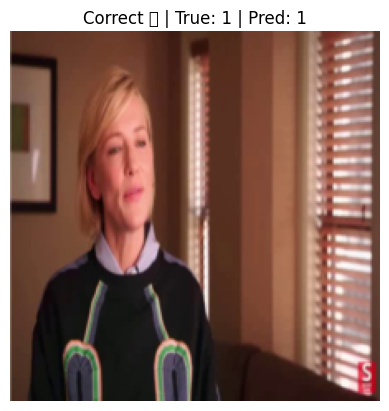

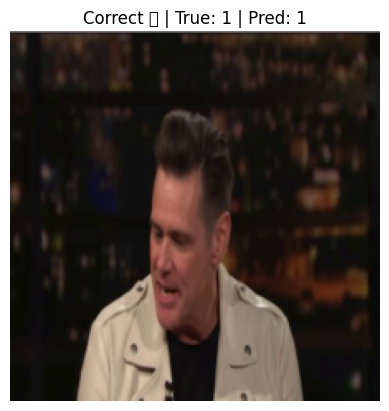

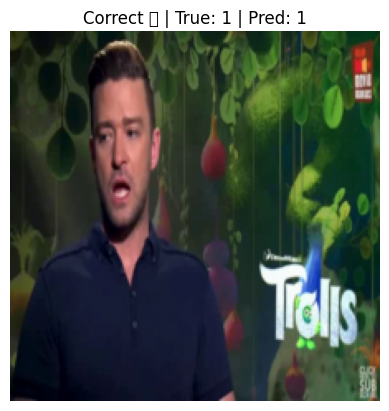

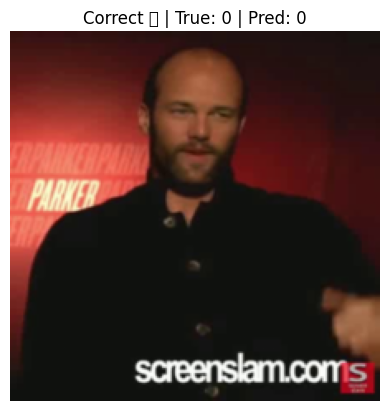

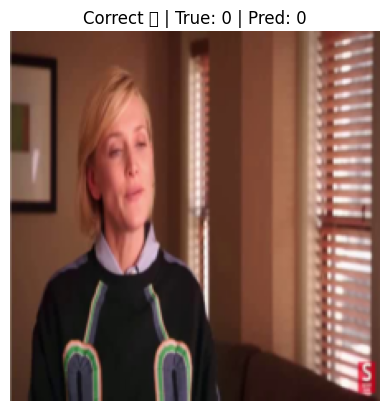

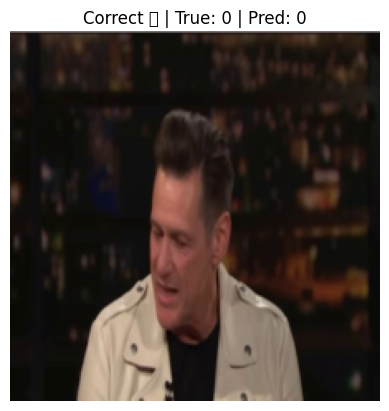

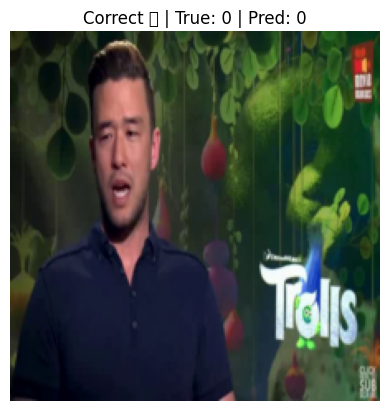

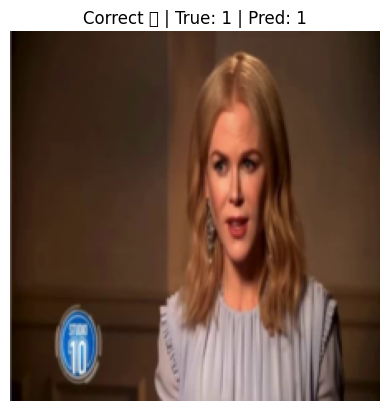

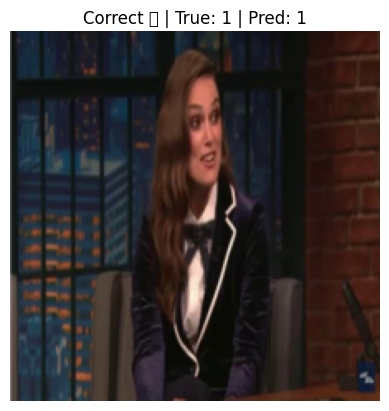

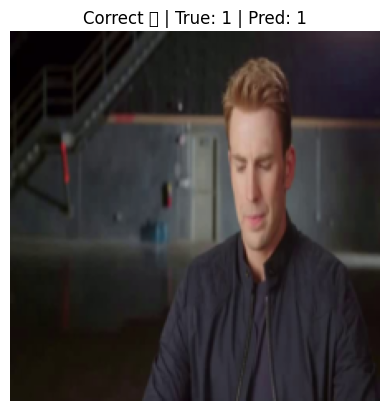

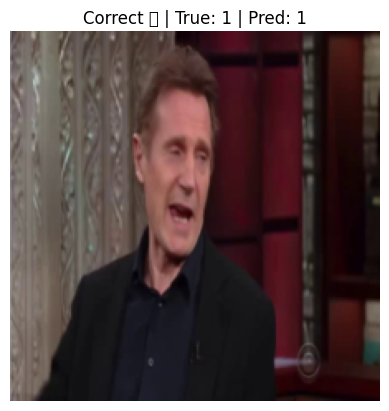

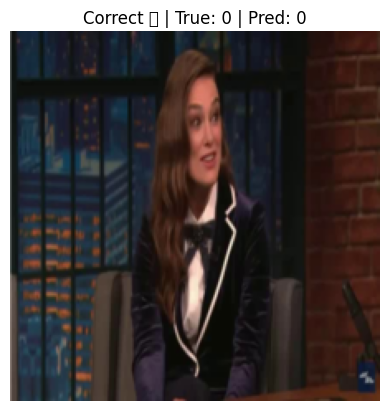

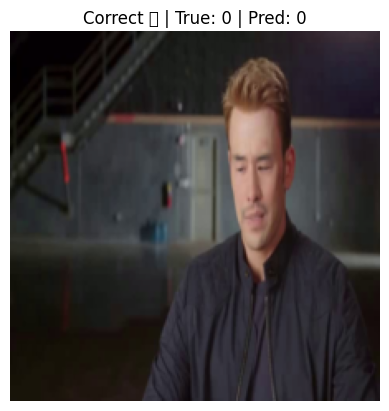


❌ Plotting 20 Incorrect Predictions:


c:\Users\najib\anaconda3\envs\PMP_LLMs\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


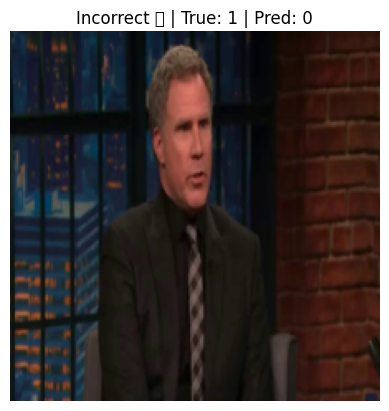

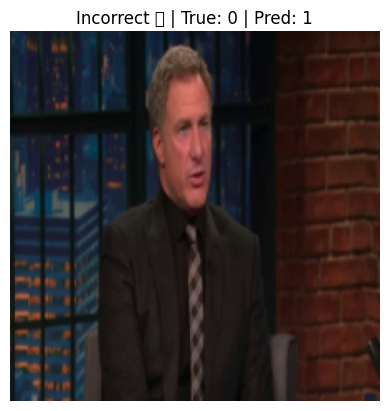

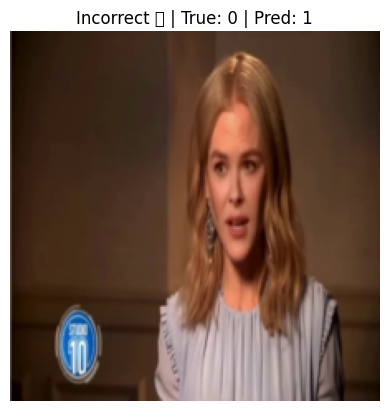

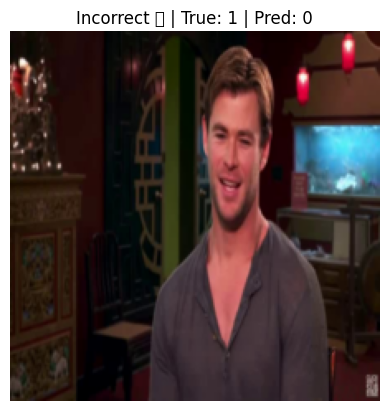

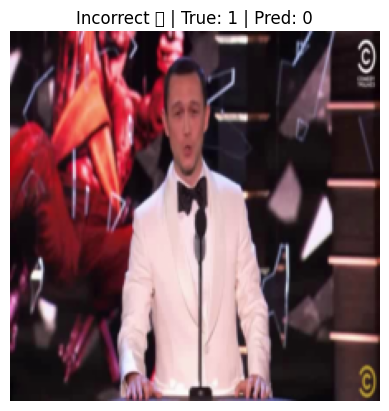

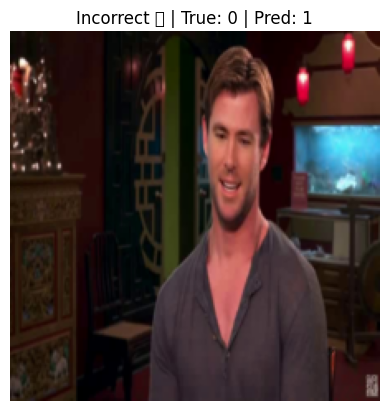

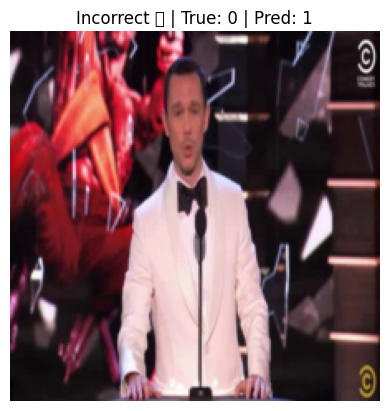

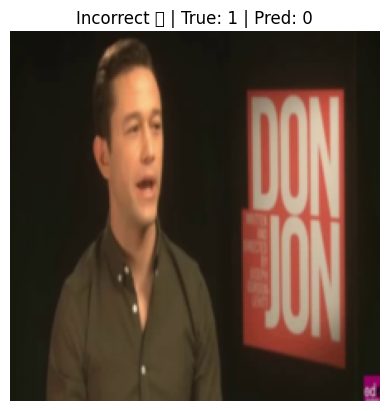

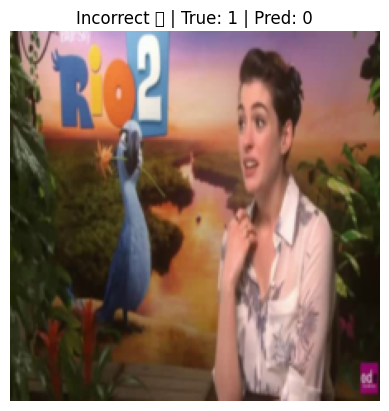

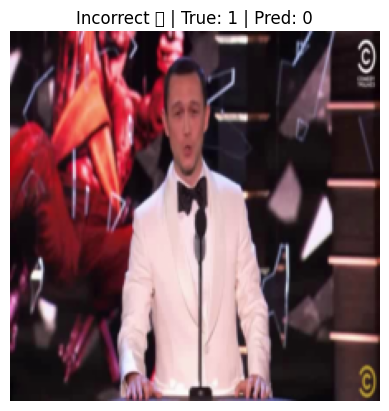

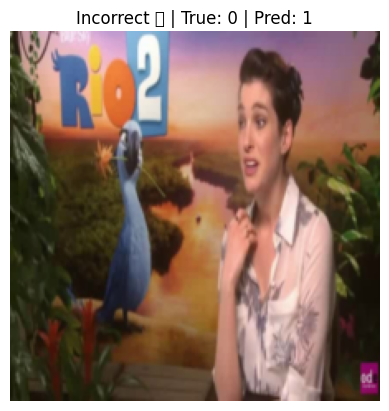

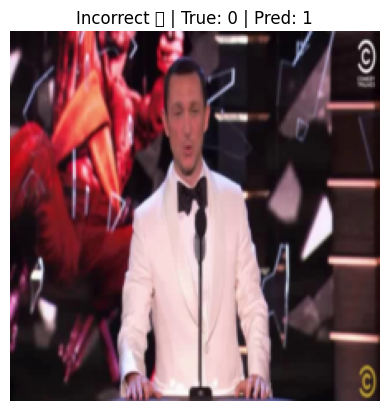

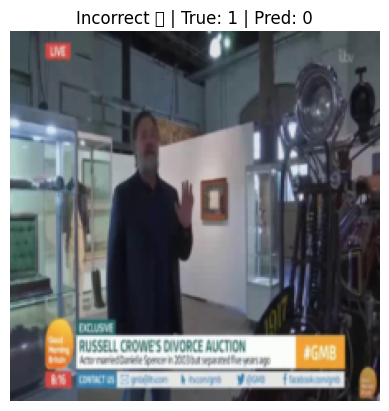

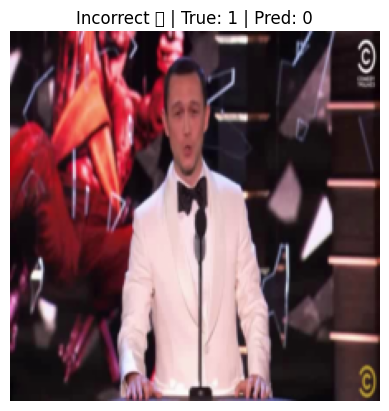

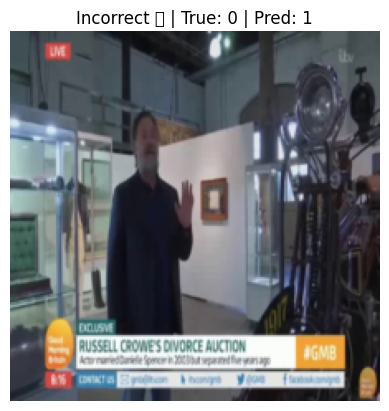

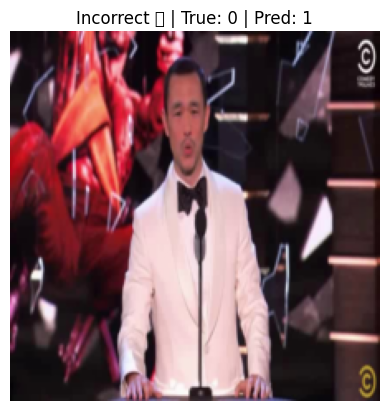

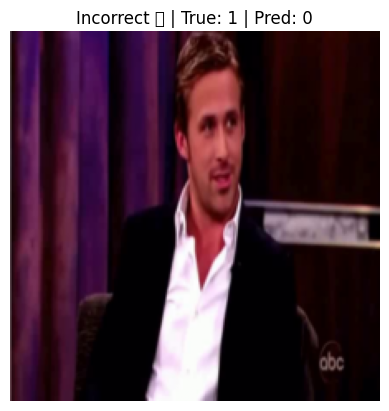

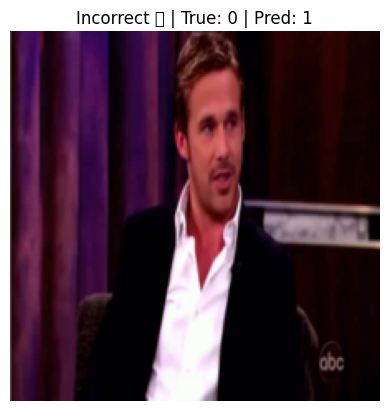

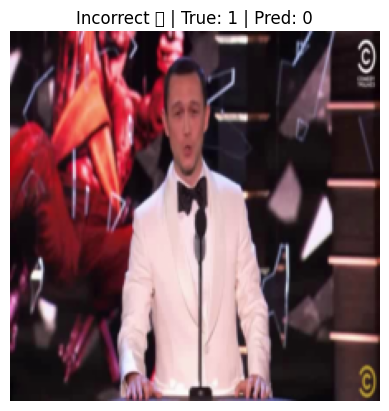

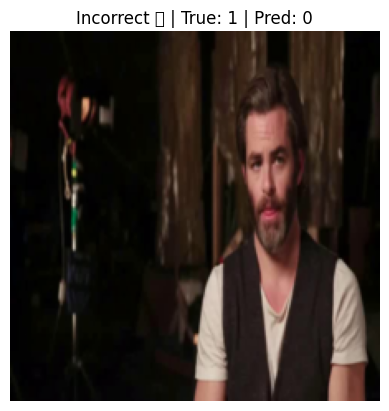

In [27]:
# -------------------------------------------
# 🖼️ Plot Examples On Demand
# -------------------------------------------
def plot_examples(examples, num_to_plot=5, correct=True):
    """
    Plots examples from the stored data.
    Args:
        examples: List of (img_tensor, true_label, pred_label, is_correct)
        num_to_plot: Number of examples to plot
        correct: True for correct examples, False for incorrect
    """
    count = 0
    for img_tensor, true_label, pred_label, is_correct in examples:
        if is_correct == correct:
            label = f"{'Correct ✅' if is_correct else 'Incorrect ❌'} | True: {true_label} | Pred: {pred_label}"
            plot_image(img_tensor, title=label)
            count += 1
            if count >= num_to_plot:
                break

# Example Usage:
num_to_plot = 20
print(f"\n✅ Plotting {num_to_plot} Correct Predictions:")
plot_examples(all_examples, num_to_plot=num_to_plot, correct=True)

print(f"\n❌ Plotting {num_to_plot} Incorrect Predictions:")
plot_examples(all_examples, num_to_plot=num_to_plot, correct=False)

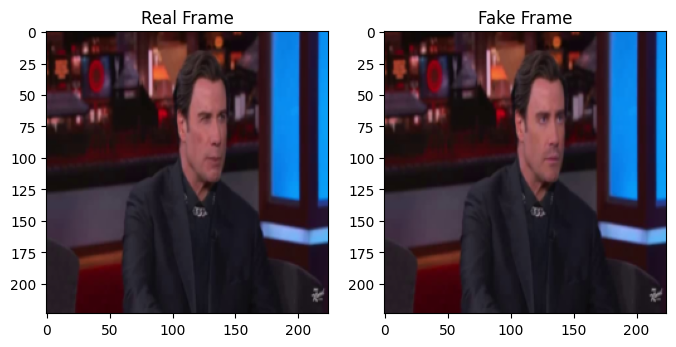

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Sample images
real_frame = real_batch[0][0]  # First video, first frame
fake_frame = fake_batch[0][0]

import torchvision.transforms as T

# De-normalize function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# De-normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

real_frame = denormalize(real_frame.clone(), mean, std)
fake_frame = denormalize(fake_frame.clone(), mean, std)

# Plot properly de-normalized images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(real_frame.permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Real Frame")
axs[1].imshow(fake_frame.permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Fake Frame")
plt.show()



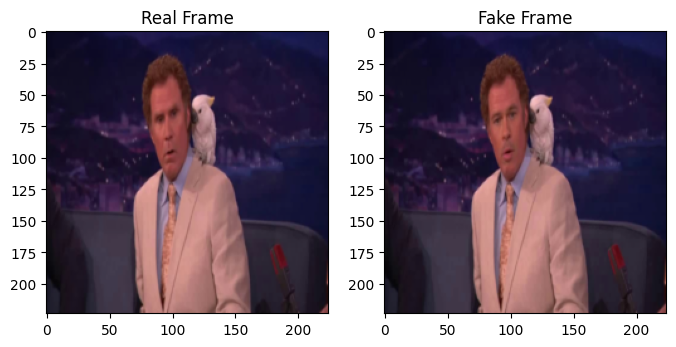

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Sample images
real_frame = real_batch[0][0]  # First video, first frame
fake_frame = fake_batch[0][0]

import torchvision.transforms as T

# De-normalize function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# De-normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

real_frame = denormalize(real_frame.clone(), mean, std)
fake_frame = denormalize(fake_frame.clone(), mean, std)

# Plot properly de-normalized images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(real_frame.permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Real Frame")
axs[1].imshow(fake_frame.permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Fake Frame")
plt.show()

